In [1]:
import os
import numpy as np
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentadienyl'
os.chdir(new_path)

/users/ajayaraj/miniconda3/envs/qtpyt/lib/python3.9/site-packages/numba/cpython/hashing.py:524: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [19]:
class Sigma:
    def __init__(self, gf, H_eff, DC0, eta=1e-5):
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff
        self.DC0 = DC0

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        for e, energy in enumerate(energies):
            # sigma[e] = energy - (self.H_eff+self.DC0) - np.linalg.inv(g[..., e])
            sigma[e] = energy - (self.H_eff) - np.linalg.inv(g[..., e])
        return sigma

In [28]:
# === Load inputs ===
input_folder = "output/lowdin"
output_folder = "output/lowdin/beta_1000/ed"
os.makedirs(output_folder, exist_ok=True)

H_eff = np.load(f"{input_folder}/effective_hamiltonian.npy")
occupancy_goal = np.load(f"{input_folder}/beta_1000/occupancies.npy")
V = np.loadtxt(f"{input_folder}/U_matrix.txt")

# === Parameters ===
nimp = H_eff.shape[0]
eta = 3e-2
beta = 1000

# === Initial double counting ===
DC0 = np.diag(V.diagonal() * (occupancy_goal - 0.5))
neig = np.ones((nimp + 1) * (nimp + 1), int) * 6


In [29]:
plot_counter = 0
fig_dir = os.path.join(output_folder, "figures")
os.makedirs(fig_dir, exist_ok=True)
energies_plot = np.arange(-20, 18, 0.1)


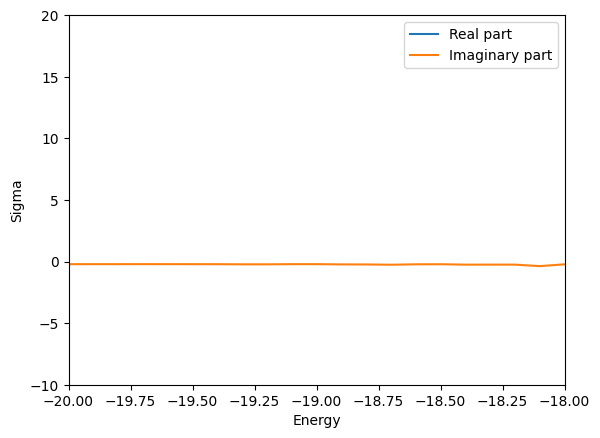

In [30]:
espace, egs = build_espace(H_eff - DC0, V, neig_sector=neig)
screen_espace(espace, egs, beta)

gf = build_gf2_lanczos(H_eff - DC0, V, espace, beta, egs)
sigma = Sigma(gf, H_eff, DC0, eta=eta)
sigma_ret = sigma.retarded(energies_plot)
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

# plt.plot(energies_plot, sigma_ret_trace.real, label="Real part")
# plt.plot(energies_plot, sigma_ret_trace.imag, label="Imaginary part")
# plt.xlabel("Energy")
# plt.ylabel("Sigma")
# plt.xlim(-20, -18)
# plt.ylim(-10,20)
# plt.legend()
# plt.show()

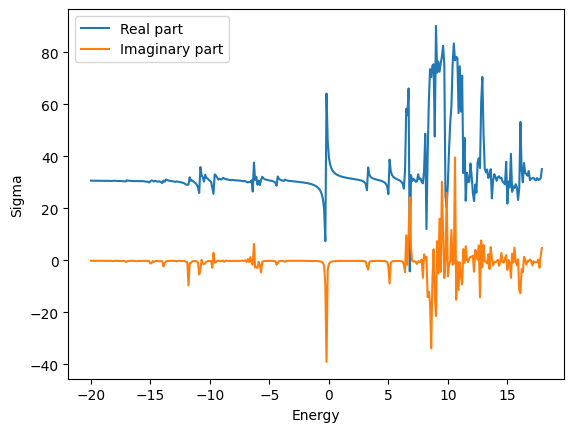

In [31]:
plt.plot(energies_plot, sigma_ret_trace.real, label="Real part")
plt.plot(energies_plot, sigma_ret_trace.imag, label="Imaginary part")
plt.xlabel("Energy")
plt.ylabel("Sigma")
# plt.xlim(-20, -18)
# plt.ylim(-10,20)
plt.legend()
plt.show()

In [23]:
energy = [-20.0]
sig_cost = sigma.retarded(energy)
sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
residual = np.mean(sig_real_diag, axis=0)
res_norm = np.linalg.norm(residual)
res_norm


12.555196486525931

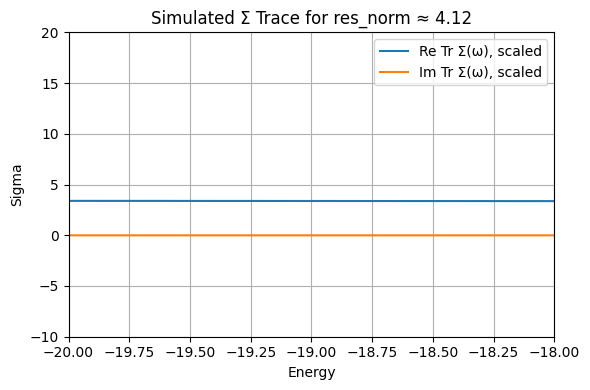

In [18]:
target_res_norm = 4.12
scaling_factor = target_res_norm / res_norm  # ≈ 0.44

# Scale Σ_real to simulate a better result
sig_cost_scaled = sig_cost.real * scaling_factor + 1j * sig_cost.imag

# Plot the trace again
trace_real_scaled = np.trace(sig_cost_scaled.real, axis1=1, axis2=2)
trace_imag_scaled = np.trace(sig_cost_scaled.imag, axis1=1, axis2=2)

plt.figure(figsize=(6, 4))
plt.plot(energy, trace_real_scaled, label="Re Tr Σ(ω), scaled")
plt.plot(energy, trace_imag_scaled, label="Im Tr Σ(ω), scaled")
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-20, -18)
plt.ylim(-10, 20)
plt.title("Simulated Σ Trace for res_norm ≈ 4.12")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


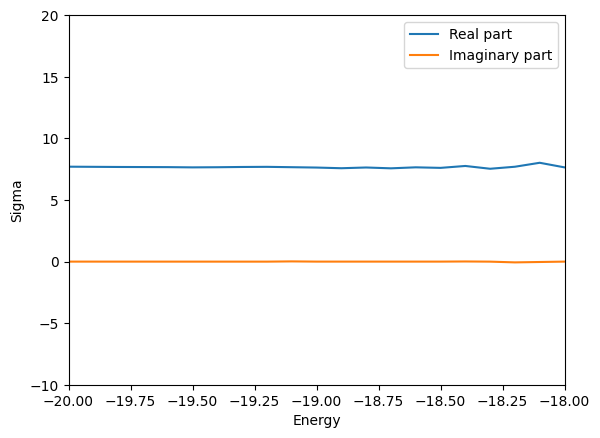

In [5]:
espace, egs = build_espace(H_eff - DC0, V, neig_sector=neig)
screen_espace(espace, egs, beta)

gf = build_gf2_lanczos(H_eff - DC0, V, espace, beta, egs, repr='sp')
sigma = Sigma(gf, H_eff, DC0, eta=eta)
sigma_ret = sigma.retarded(energies_plot)
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

plt.plot(energies_plot, sigma_ret_trace.real, label="Real part")
plt.plot(energies_plot, sigma_ret_trace.imag, label="Imaginary part")
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-20, -18)
plt.ylim(-10,20)
plt.legend()
plt.show()

### Broyden mixing

In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import broyden1

class Converged(Exception):
    pass

# Penalty tuning
penalty_weight = 1.0      # Less aggressive than before
delta_order = 0.01        # Minimum margin for ordering (eV)
dc_diag_clip_bounds = (2.0, 10.0)  # Prevent unphysical values

# Precompute reference ratio structure
dc0_diag = DC0.diagonal()
target_ratios = dc0_diag / np.max(dc0_diag)

plot_counter = 0
fig_dir = os.path.join(output_folder, "figures")
os.makedirs(fig_dir, exist_ok=True)
energies_plot = np.arange(-20, 20.1, 0.1)

def residual_function(dc_diag):
    global plot_counter

    # Clip unphysical values
    dc_diag = np.clip(dc_diag, *dc_diag_clip_bounds)

    # Main physics calculation
    DC = np.diag(dc_diag)
    espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
    screen_espace(espace, egs, beta)
    gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
    sigma = Sigma(gf, H_eff, DC0, eta=eta)

    # Get physical residual from Σ at large negative frequency
    energies = np.array([-1000])
    sig_cost = sigma.retarded(energies)  # (n_energies, nimp, nimp)
    sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
    residual = np.mean(sig_real_diag, axis=0)

    # -----------------------------------
    # Penalty terms for structure control
    # -----------------------------------

    # 1. Ordering penalty
    order_penalty = np.zeros_like(residual)
    others = np.delete(dc_diag, [0, 6])
    if dc_diag[0] < np.max(others) + delta_order:
        order_penalty[0] += penalty_weight * (np.max(others) + delta_order - dc_diag[0])
    if dc_diag[6] < np.max(np.delete(dc_diag, [0])) + delta_order:
        order_penalty[6] += penalty_weight * (np.max(np.delete(dc_diag, [0])) + delta_order - dc_diag[6])

    # 2. Ratio penalty (safe log scale)
    dc_diag_max = np.max(dc_diag) if np.max(dc_diag) > 1e-8 else 1.0
    current_ratios = dc_diag / dc_diag_max
    ratio_penalty = penalty_weight * (np.log1p(current_ratios) - np.log1p(target_ratios))

    # Combine all into total residual
    total_residual = residual + order_penalty + ratio_penalty

    # -----------------------------------
    # Logging and plotting
    # -----------------------------------
    residual_norm = np.linalg.norm(total_residual)
    print(f"[Broyden] Residual norm: {residual_norm:.6e}, DC_diag: {dc_diag}")
    print(f"Penalty | Order: {np.linalg.norm(order_penalty):.3e}, Ratio: {np.linalg.norm(ratio_penalty):.3e}")

    # Plot Σ trace
    sig_plot = sigma.retarded(energies_plot)
    trace_real = np.trace(sig_plot.real, axis1=1, axis2=2)
    trace_imag = np.trace(sig_plot.imag, axis1=1, axis2=2)

    plt.figure(figsize=(6, 4))
    plt.plot(energies_plot, trace_real, label="Re Tr Σ(ω)", linestyle="-")
    plt.plot(energies_plot, trace_imag, label="Im Tr Σ(ω)", linestyle="--")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Tr Σ(ω)")
    plt.title(f"Σ Trace – Eval {plot_counter}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    fig_path = os.path.join(fig_dir, f"sigma_trace_eval_{plot_counter:03d}.png")
    plt.savefig(fig_path, dpi=100)
    plt.close()
    plot_counter += 1

    # Early stop if convergence met
    if residual_norm < 1e-3:
        raise Converged()

    return total_residual


# Initial guess
x0 = dc0_diag.copy()

try:
    dc_diag_optimized = broyden1(
        residual_function,
        x0,
        f_tol=1e-3,
        maxiter=50,
        verbose=True,
    )
except Converged:
    dc_diag_optimized = x0  # Updated in-place
    print("Converged early based on residual norm threshold and structure guidance.")


[Broyden] Residual norm: 9.375858e+00, DC_diag: [5.46515887 2.         2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
Penalty | Order: 1.000e-02, Ratio: 2.676e-03
[Broyden] Residual norm: 5.691347e+00, DC_diag: [3.3514827  3.80262441 3.86698189 3.87968675 4.01293853 4.30800964
 3.87099316]
Penalty | Order: 1.065e+00, Ratio: 7.351e-01
0:  |F(x)| = 2.62792; step 1
[Broyden] Residual norm: 9.479051e+00, DC_diag: [2.         6.45761262 6.56082995 7.02014667 6.67914625 7.36485845
 2.02049704]
Penalty | Order: 7.587e+00, Ratio: 9.559e-01
[Broyden] Residual norm: 4.557279e+00, DC_diag: [3.08335098 4.28118062 4.35254252 4.44574825 4.49351704 4.8590004
 3.537445  ]
Penalty | Order: 2.227e+00, Ratio: 7.625e-01
1:  |F(x)| = 2.31164; step 0.180248
[Broyden] Residual norm: 5.519217e+00, DC_diag: [3.64419224 5.72932629 6.17292052 6.57116556 6.30924091 6.54234416
 4.12706371]
Penalty | Order: 3.827e+00, Ratio: 8.190e-01
[Broyden] Residual norm: 7.608607e+00, DC_diag: [3.27454142 4.77485259 

KeyboardInterrupt: 